# Defining fully anisotropic materials

`Tidy3D`'s capabilities include modeling of non-dispersive [fully anisotropic materials](../_autosummary/tidy3d.FullyAnisotropicMedium.html). In this tutorial we explain how to set up and run a simulation containing such materials. Specifically, we will consider scattering of a plane wave from fully anisotropic dielectric spheres and compare results to an equivalent setup containing only diagonally anisotropic materials.

For simulation examples, please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/). If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.

## Simulation setup

In [1]:
# standard python imports
import numpy as np
import xarray as xr
import matplotlib.pylab as plt

# tidy3D import
import tidy3d as td
from tidy3d.constants import C_0
import tidy3d.web as web

We start with defining the simulation domain as a cube with side length of 1.6 um, and selecting 11 sample frequencies in the vicinity of the wavelength of interest $\lambda = 1$ um. 

In [2]:
sim_size = (1.6, 1.6, 1.6)

wvl_um = 1
freq0 = td.C_0 / wvl_um
fwidth = freq0 / 10
num_freqs = 11
freqs = np.linspace(freq0 - fwidth / 2, freq0 + fwidth / 2, num_freqs)
find0 = num_freqs // 2

run_time = 10 / fwidth

Next we define main permittivity and conductivity components of medium we would like to simulate.

In [3]:
permittivity_main = (15, 10, 5)
conductivity_main = (0.01, 0.02, 0.03)

We will create 3 different anisotropic media to use and compare in 3 different simulations. First, a diagonally anisotropic medium that will be used in a reference simulation is created using the familiar [AnisotropicMedium](../_autosummary/tidy3d.AnisotropicMedium.html) class.

In [4]:
# diagonally anisotropic material
medium_diag = td.AnisotropicMedium(
    xx=td.Medium(permittivity=permittivity_main[0], conductivity=conductivity_main[0]),
    yy=td.Medium(permittivity=permittivity_main[1], conductivity=conductivity_main[1]),
    zz=td.Medium(permittivity=permittivity_main[2], conductivity=conductivity_main[2]),
)

Next, we would like to create two fully anisotropic media obtained as rotations of the above diagonally anisotropic medium around x and z axes, respectively. Fully anisotropic materials are created using class [FullyAnisotropicMedium](../_autosummary/tidy3d.FullyAnisotropicMedium.html), which requires full permittivity and conductivity tensor during initialization. `Tidy3D` provides a convenience class [RotationAroundAxis](../_autosummary/tidy3d.RotationAroundAxis.html) that can be used for transformation of material property tensors. Using it we can define a fully anisotropic medium in two ways. First, one can use this class directly to perform rotation of material property tensors, and then use the resulting tensors to initialize a `FullyAnisotropicMedium` as following.

In [5]:
# Fully anisotropic media obtained as a rotation around x axis by angle phi
phi = np.pi / 3

# create diagonal tensor
permittivity_phi = np.diag(permittivity_main)
conductivity_phi = np.diag(conductivity_main)

# create rotation around axis
rotation_around_x = td.RotationAroundAxis(axis=(1, 0, 0), angle=phi)

# transform material property tensors
permittivity_phi = rotation_around_x.rotate_tensor(permittivity_phi)
conductivity_phi = rotation_around_x.rotate_tensor(conductivity_phi)

# define a fully anisotropic medium
medium_phi = td.FullyAnisotropicMedium(
    permittivity=permittivity_phi, conductivity=conductivity_phi
)

The alternative way is to use a shortcut class method `FullyAnisotropicMedium.from_diagonal()` that performs the necessary tensor transformations internally. Note that this class method follows the signature of `AnisotropicMedium` class, that is, it expects main components of material properties defined as `Medium`'s.

In [6]:
# Fully anisotropic media obtained as a rotation around z axis by angle theta
theta = np.pi / 7

# create rotation around axis
rotation_around_z = td.RotationAroundAxis(axis=(0, 0, 1), angle=theta)

# define a fully anisotropic medium as a transformation of diagonally anisotropic medium
medium_theta = td.FullyAnisotropicMedium.from_diagonal(
    xx=td.Medium(permittivity=permittivity_main[0], conductivity=conductivity_main[0]),
    yy=td.Medium(permittivity=permittivity_main[1], conductivity=conductivity_main[1]),
    zz=td.Medium(permittivity=permittivity_main[2], conductivity=conductivity_main[2]),
    rotation=rotation_around_z,
)

One can confirm that the three created media have identical main components by visualizing their complex refractive indexes using the built-in function `.plot()`. Note that in case of fully anisotropic materials the direction of each main component is provided in figure legend as they are no longer aligned with Cartesian directions.

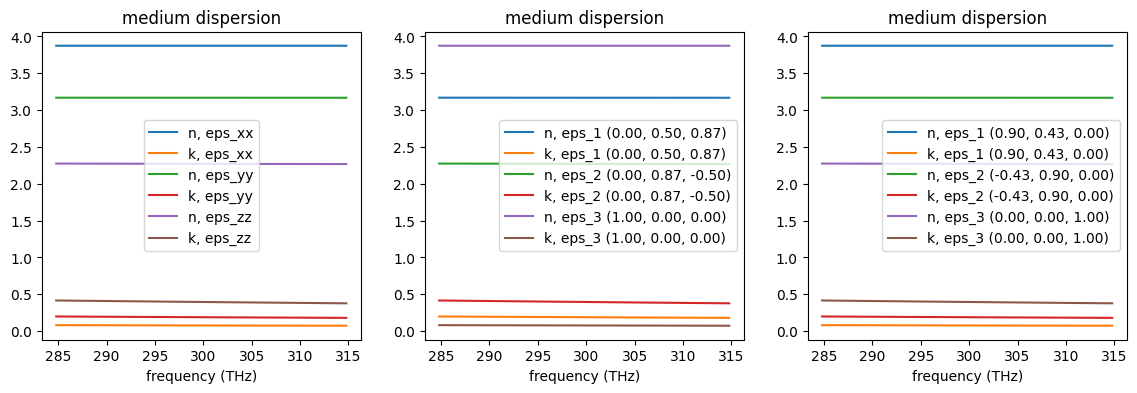

In [7]:
# Visualize material properties
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
medium_diag.plot(freqs, ax=ax[0])
medium_phi.plot(freqs, ax=ax[1])
medium_theta.plot(freqs, ax=ax[2])
plt.show()

Create three spheres of the same size but made of different anisotropic materials.

In [8]:
sphere_diag = td.Structure(geometry=td.Sphere(center=(0, 0, 0), radius=0.3), medium=medium_diag)
sphere_phi = sphere_diag.updated_copy(medium=medium_phi)
sphere_theta = sphere_diag.updated_copy(medium=medium_theta)

To set up three equivalent simulations we use [TFSF](../_autosummary/tidy3d.TFSF.html) sources injecting plane waves whose propagation fronts are rotated in the same way as the material properties of the three anisotropic media.

In [9]:
source_diag = td.TFSF(
    center=(0, 0, 0),
    size=(1.1, 1.1, 1.1),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    injection_axis=0,
    direction="+",
    name="tfsf",
    angle_phi=0,
    angle_theta=0,
    pol_angle=0,
)

source_phi = source_diag.updated_copy(angle_phi=phi)
source_theta = source_diag.updated_copy(angle_theta=theta)

For a quantitative comparison of results of the three equivalent simulation we monitor total scattered flux from the sphere and field distribution in two orthogonal planes.

In [10]:
mnt_flux = td.FluxMonitor(center=(0, 0, 0), size=(1.3, 1.3, 1.3), freqs=freqs, name="flux")
mnt_field_yz = td.FieldMonitor(center=(0, 0, 0), size=(0, td.inf, td.inf), freqs=freqs, name="field_yz")
mnt_field_xy = td.FieldMonitor(center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=freqs, name="field_xy")

[11:22:20] WARNING: Default value for the field monitor           ]8;id=501155;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=829333;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

           WARNING: Default value for the field monitor           ]8;id=375415;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=151508;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

PML boundary conditions are placed on each side of the simulation domain and a simple uniform grid is used for grid discretization. 

In [11]:
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())
grid_spec = td.GridSpec.uniform(dl=0.005)

Combining all the components defined above we create three equivalent simulations which are rotations of each other.

In [12]:
sim_diag = td.Simulation(
    center=(0, 0, 0),
    size=sim_size,
    grid_spec=grid_spec,
    structures=[sphere_diag],
    sources=[source_diag],
    monitors=[mnt_flux, mnt_field_yz, mnt_field_xy],
    run_time=run_time,
    boundary_spec=boundary_spec,
)

sim_phi = sim_diag.updated_copy(structures=[sphere_phi], sources=[source_phi])
sim_theta = sim_diag.updated_copy(structures=[sphere_theta], sources=[source_theta])

Visualize simulation setups for confirmation.

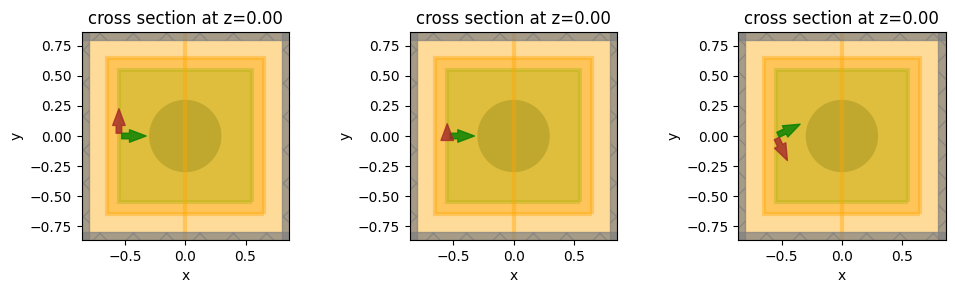

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
sim_diag.plot(z=0, ax=ax[0])
sim_phi.plot(z=0, ax=ax[1])
sim_theta.plot(z=0, ax=ax[2])
plt.tight_layout()
plt.show()

## Results

Submit and run simulations on the server.

In [14]:
sim_data_diag = web.run(simulation=sim_diag, task_name="fully_anisotropic_diag", path="data/simulation_data_diag.hdf5", verbose=True)
sim_data_phi = web.run(simulation=sim_phi, task_name="fully_anisotropic_phi", path="data/simulation_data_phi.hdf5", verbose=True)
sim_data_theta = web.run(simulation=sim_theta, task_name="fully_anisotropic_theta", path="data/simulation_data_theta.hdf5", verbose=True)

[11:22:21] Created task 'fully_anisotropic_diag' with task_id      ]8;id=354274;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=215437;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-459be39f-bd2a-42f2-93b5-59e89ed420b6v1'.                       

           View task using web UI at                               ]8;id=570050;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=558697;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=233778;https://tidy3d.simulation.cloud/workbench?taskId=fdve-459be39f-bd2a-42f2-93b5-59e89ed420b6v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=391962;https://tidy3d.simulation.cloud/workbench?taskId=fdve-459be39f-bd2a-42f2-93b5-59e89ed420b6v1\taskId]8;;\]8;id=233778;https://tidy3d.simulation.cloud/workbench?taskId=fdve-459be39f-bd2a-42f2-93b5-59e89ed420b6v1\=]8;;\]8;id=252936;https://tidy3d.simulation.cloud/workbench?taskId=fdve-459be39f-bd2a-42f2-93b5-59e89ed420b6v1\fdve]8;;\]8;id=233778;https://tidy3d.simulation.cloud/workbench?taskId=fdve-459be39f-bd2a-42f2-93b5-59e89ed420b6v1\-]8;;\              
           ]8;id=233778;https://tidy3d.simulation.cloud/workbench?taskId=fdve-459be39f-bd2a-42f2-93b5-59e89ed420b6v1\459be39f-bd2a-42f2-93b5-59e89ed420b6v1']8;;\.                             

Output()

[11:22:22] status = queued                                         ]8;id=100830;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=917702;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#361\361]8;;\

Output()

[11:22:31] status = preprocess                                     ]8;id=807001;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=827137;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#355\355]8;;\

[11:22:35] Maximum FlexCredit cost: 0.435. Use                     ]8;id=469186;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=744109;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=984434;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=71279;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=745458;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=311079;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=385811;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=214423;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[11:23:08] early shutoff detected, exiting.                        ]8;id=197898;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=424461;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=272544;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=658718;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#419\419]8;;\

Output()

[11:23:14] status = success                                        ]8;id=311680;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=706114;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#426\426]8;;\

Output()

[11:23:19] loading SimulationData from                             ]8;id=464610;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=130077;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/simulation_data_diag.hdf5                                       

           Created task 'fully_anisotropic_phi' with task_id       ]8;id=838463;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=271998;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-663b15c7-be47-484c-a491-c90896e9d50ev1'.                       

           View task using web UI at                               ]8;id=953765;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=572556;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=723745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-663b15c7-be47-484c-a491-c90896e9d50ev1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=660857;https://tidy3d.simulation.cloud/workbench?taskId=fdve-663b15c7-be47-484c-a491-c90896e9d50ev1\taskId]8;;\]8;id=723745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-663b15c7-be47-484c-a491-c90896e9d50ev1\=]8;;\]8;id=563031;https://tidy3d.simulation.cloud/workbench?taskId=fdve-663b15c7-be47-484c-a491-c90896e9d50ev1\fdve]8;;\]8;id=723745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-663b15c7-be47-484c-a491-c90896e9d50ev1\-]8;;\              
           ]8;id=723745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-663b15c7-be47-484c-a491-c90896e9d50ev1\663b15c7-be47-484c-a491-c90896e9d50ev1']8;;\.                             

Output()

[11:23:21] status = queued                                         ]8;id=583777;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=307390;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#361\361]8;;\

Output()

[11:23:29] status = preprocess                                     ]8;id=912398;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=727647;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#355\355]8;;\

[11:23:32] Maximum FlexCredit cost: 0.705. Use                     ]8;id=161039;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=211404;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=171061;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=318076;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=511799;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=242;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=320452;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=689347;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[11:24:16] early shutoff detected, exiting.                        ]8;id=905096;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=833594;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=87950;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=906079;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#419\419]8;;\

Output()

[11:24:21] status = success                                        ]8;id=969996;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=389695;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#426\426]8;;\

Output()

[11:24:26] loading SimulationData from                             ]8;id=943358;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=280761;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/simulation_data_phi.hdf5                                        

           Created task 'fully_anisotropic_theta' with task_id     ]8;id=70508;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=455889;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-323e9156-2992-4bc2-88c8-2a325ed4592dv1'.                       

           View task using web UI at                               ]8;id=203152;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=521269;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=311872;https://tidy3d.simulation.cloud/workbench?taskId=fdve-323e9156-2992-4bc2-88c8-2a325ed4592dv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=607217;https://tidy3d.simulation.cloud/workbench?taskId=fdve-323e9156-2992-4bc2-88c8-2a325ed4592dv1\taskId]8;;\]8;id=311872;https://tidy3d.simulation.cloud/workbench?taskId=fdve-323e9156-2992-4bc2-88c8-2a325ed4592dv1\=]8;;\]8;id=420320;https://tidy3d.simulation.cloud/workbench?taskId=fdve-323e9156-2992-4bc2-88c8-2a325ed4592dv1\fdve]8;;\]8;id=311872;https://tidy3d.simulation.cloud/workbench?taskId=fdve-323e9156-2992-4bc2-88c8-2a325ed4592dv1\-]8;;\              
           ]8;id=311872;https://tidy3d.simulation.cloud/workbench?taskId=fdve-323e9156-2992-4bc2-88c8-2a325ed4592dv1\323e9156-2992-4bc2-88c8-2a325ed4592dv1']8;;\.                             

Output()

[11:24:27] status = queued                                         ]8;id=895924;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=650512;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#361\361]8;;\

Output()

[11:24:38] status = preprocess                                     ]8;id=131984;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=525586;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#355\355]8;;\

[11:24:41] Maximum FlexCredit cost: 0.705. Use                     ]8;id=601455;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=871384;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=102753;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=966805;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=15149;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=799875;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=742156;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=603126;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[11:25:24] early shutoff detected, exiting.                        ]8;id=518819;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=147376;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=555317;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=556218;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#419\419]8;;\

Output()

[11:25:30] status = success                                        ]8;id=451274;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=18294;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#426\426]8;;\

Output()

[11:25:37] loading SimulationData from                             ]8;id=9719;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=458722;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/simulation_data_theta.hdf5                                      

To confirm that the three simulation produces close results we first consider the total scattered flux from the sphere. The slight difference in obtained results is attributed to the fact that currently `Tidy3D` does not support subpixel averaging for fully anisotropic materials. 

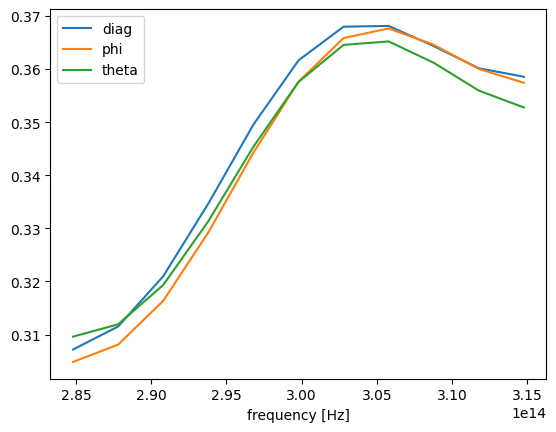

In [15]:
# retrive flux values from flux monitor
flux_diag = sim_data_diag["flux"].flux
flux_phi = sim_data_phi["flux"].flux
# scale power by injection angle
flux_theta = sim_data_theta["flux"].flux * np.cos(theta)

# visualize
flux_diag.plot()
flux_phi.plot()
flux_theta.plot()
plt.legend(["diag", "phi", "theta"])
plt.show()

Now we look at the angular field intensity distributions around the sphere at several distances from the sphere's center.

In [16]:
# field sample locations
sample_radius = [0.1, 0.2, 0.4, 0.5]
sample_angle = np.linspace(0, 2 * np.pi, 100)

When comparing the reference (diagonally anisotropic) simulation with the simulation obtained by rotation around $x$ axis we use the fact that field distributions must coincide in the $yz$ plane when appropriately rotated.

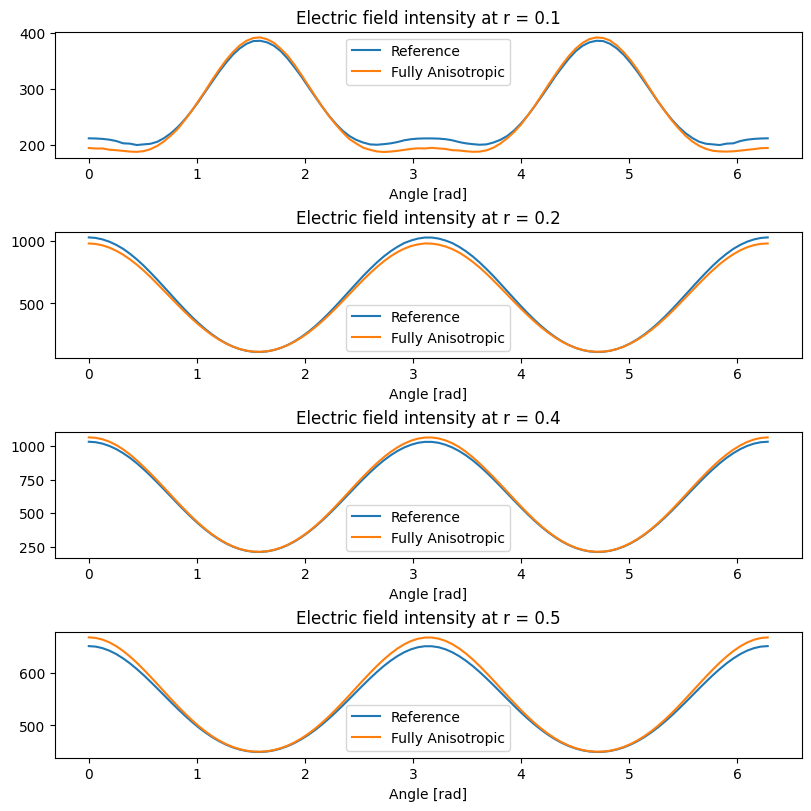

In [17]:
# get field intensity distribution at central frequency
int_diag = sim_data_diag.get_intensity("field_yz").isel(x=0, f=find0)
int_full = sim_data_phi.get_intensity("field_yz").isel(x=0, f=find0)

fig, ax = plt.subplots(len(sample_radius), 1, constrained_layout=True, figsize=(8, 8))

for i, r in enumerate(sample_radius):
    # sample points in reference simulation
    y_diag = xr.DataArray(r * np.cos(sample_angle), dims="u")
    z_diag = xr.DataArray(r * np.sin(sample_angle), dims="u")

    # rotated sample points in fully anisotropic simulation
    y_full = xr.DataArray(r * np.cos(sample_angle + phi), dims="u")
    z_full = xr.DataArray(r * np.sin(sample_angle + phi), dims="u")

    # interpolate at sample points
    int_sampled_diag = int_diag.interp(y=y_diag, z=z_diag)
    int_sampled_full = int_full.interp(y=y_full, z=z_full)

    # plot comparisons
    ax[i].plot(sample_angle, int_sampled_diag.data)
    ax[i].plot(sample_angle, int_sampled_full.data)
    ax[i].set_xlabel("Angle [rad]")
    ax[i].legend(["Reference", "Fully Anisotropic"])
    ax[i].set_title(f"Electric field intensity at r = {r}")

plt.show()

When comparing the reference (diagonally anisotropic) simulation with the simulation obtained by rotation around $z$ axis we use the fact that field distributions must coincide in the $xy$ plane when appropriately rotated.

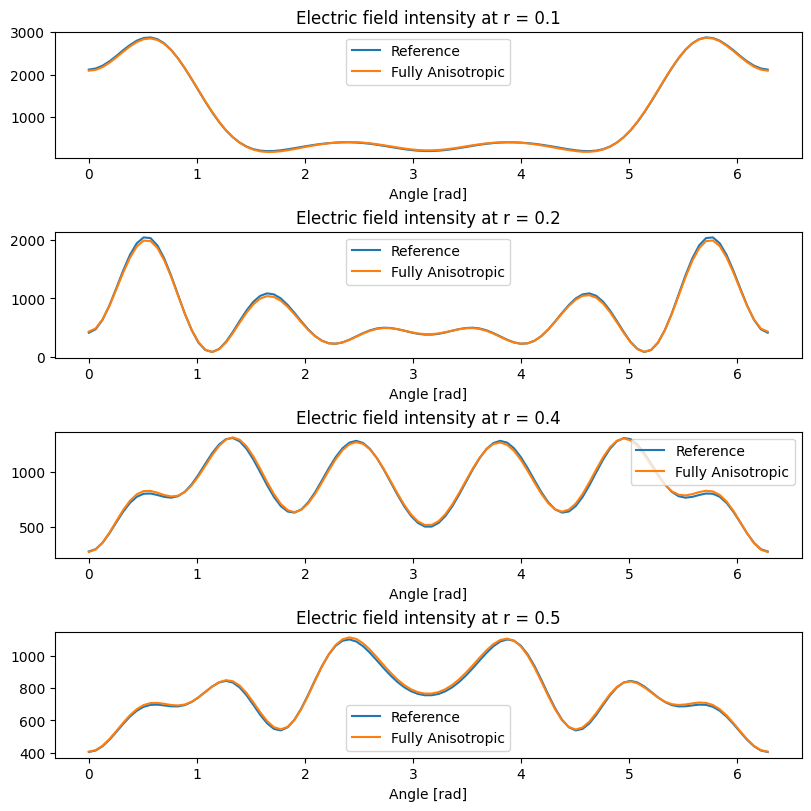

In [18]:
# get field intensity distribution at central frequency
int_diag = sim_data_diag.get_intensity("field_xy").isel(z=0, f=find0)
# scale power by the injection angle
int_full = sim_data_theta.get_intensity("field_xy").isel(z=0, f=find0) * np.cos(theta)

fig, ax = plt.subplots(len(sample_radius), 1, constrained_layout=True, figsize=(8, 8))

for i, r in enumerate(sample_radius):
    # sample points in reference simulation
    x_diag = xr.DataArray(r * np.cos(sample_angle), dims="u")
    y_diag = xr.DataArray(r * np.sin(sample_angle), dims="u")

    # rotated sample points in fully anisotropic simulation
    x_full = xr.DataArray(r * np.cos(sample_angle + theta), dims="u")
    y_full = xr.DataArray(r * np.sin(sample_angle + theta), dims="u")

    # interpolate at sample points
    int_sampled_diag = int_diag.interp(x=x_diag, y=y_diag)
    int_sampled_full = int_full.interp(x=x_full, y=y_full)

    # plot comparisons
    ax[i].plot(sample_angle, int_sampled_diag.data)
    ax[i].plot(sample_angle, int_sampled_full.data)
    ax[i].set_xlabel("Angle [rad]")
    ax[i].legend(["Reference", "Fully Anisotropic"])
    ax[i].set_title(f"Electric field intensity at r = {r}")

plt.show()

Again, we see that equivalent simulations produce very close results, and the small differences are attributed to the lack of subpixel averaging for fully anisotropic materials.

Lastly, gyrotropic materials (materials with Hermitian permittivity tensors) can also be modeled using the [fully anisotropic materials](../_autosummary/tidy3d.FullyAnisotropicMedium.html). For details, see the tutorial on [defining gyrotropic materials](https://www.flexcompute.com/tidy3d/examples/notebooks/Gyrotropic/).